In [1]:
import pandas

In [2]:
tables = pandas.read_html("https://en.wikipedia.org/wiki/List_of_oil_spills")

In [3]:
tables[1].to_csv("data/spills.csv")

In [4]:
def robust_float(x):
    try:
        return float(x)
    except ValueError:
        return float('nan')

In [5]:
tonnes = tables[1]['Max Tonnes'].apply(robust_float)

In [6]:
import re

In [7]:
y = tables[1]['Dates'].apply(lambda x: int(re.search('\d{4}', x).group()))

In [8]:
spills = y.groupby(y).size()

In [9]:
spills.index

Int64Index([1903, 1907, 1910, 1937, 1940, 1944, 1945, 1946, 1948, 1950, 1953,
            1958, 1962, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
            1976, 1977, 1978, 1979, 1980, 1981, 1983, 1984, 1985, 1986, 1987,
            1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
            1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
            2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
            2021, 2022],
           dtype='int64', name='Dates')

In [10]:
spills = spills[spills.index > 1970]

<AxesSubplot:xlabel='Dates'>

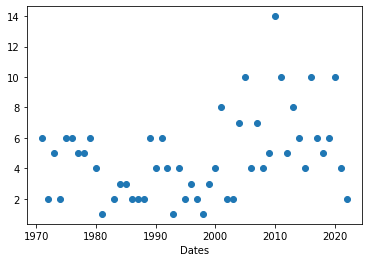

In [11]:
spills.plot(marker='o', ls='')

In [14]:
total_tonnes = tonnes.groupby(y).sum()
total_tonnes = total_tonnes[total_tonnes.index > 1970]

<AxesSubplot:xlabel='Dates'>

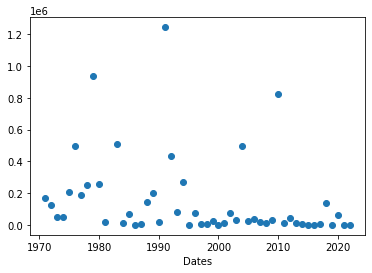

In [15]:
total_tonnes.plot(marker='o', ls='')

In [16]:
years = spills.index

In [17]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [18]:
def disaster_count_model(disaster_rate_fn):
    disaster_count = tfd.JointDistributionNamed(dict(
        e=tfd.Exponential(rate=1.),
        l=tfd.Exponential(rate=1.),
        s=tfd.Uniform(float(years.min()), float(years.max())),
        d_t=lambda s, l, e: tfd.Independent(
            tfd.Poisson(rate=disaster_rate_fn(tf.constant(years, dtype=tf.float32), s[...,tf.newaxis], l[...,tf.newaxis], e[...,tf.newaxis])),
            reinterpreted_batch_ndims=1)
    ))
    return disaster_count

def disaster_rate_switch(ys, s, l, e):
    return tf.where(ys < s, e, l)

def disaster_rate_sigmoid(ys, s, l, e):
    return e + tf.sigmoid(ys - s) * (l - e)

model_switch = disaster_count_model(disaster_rate_switch)
model_sigmoid = disaster_count_model(disaster_rate_sigmoid)

In [19]:
model_sigmoid.sample(3)

2022-10-09 21:25:50.927076: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


{'s': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1991.5247, 1982.404 , 1975.7794], dtype=float32)>,
 'l': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.86815566, 0.3003133 , 3.0220253 ], dtype=float32)>,
 'e': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.77581865, 0.33044854, 0.45834905], dtype=float32)>,
 'd_t': <tf.Tensor: shape=(3, 51), dtype=float32, numpy=
 array([[ 0.,  0.,  0.,  1.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          1.,  1.,  0.,  0.,  1.,  2.,  2.,  0.,  0.,  1.,  0.,  1.,  1.,
          3.,  1.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  0.,  0.,
          4.,  0.,  1.,  1.,  2.,  2.,  0.,  2.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
          0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
          2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  3

In [20]:
def target_log_prob_fn(model, s, e, l):
    return model.log_prob(s=s, e=e, l=l, d_t=spills)

models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, [1980.]*2, [3.]*2, [.9]*2).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 1990., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[array([-301.45364, -301.45364], dtype=float32), array([-300.24185, -300.24185], dtype=float32)]
[-169.69983, -165.9459]
[-inf, -inf]


# MAP estimate

In [21]:
s, e, l = tf.Variable(2000.), tf.Variable(1.), tf.Variable(1.)

In [22]:
loss = lambda: -target_log_prob_fn(model_sigmoid, s, e, l)

In [23]:
loss_hist = []
var_hist = {v: [] for v in ['s', 'e', 'l']}
opt = tf.optimizers.SGD(learning_rate=0.2)
for _ in range(100):
    opt.minimize(loss, [s,e,l])
    loss_hist.append(loss())
    var_hist['s'].append(s.numpy())
    var_hist['e'].append(e.numpy())
    var_hist['l'].append(l.numpy())

In [30]:
import matplotlib.pyplot as plt

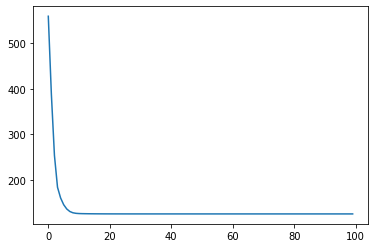

In [31]:
plt.plot(loss_hist)

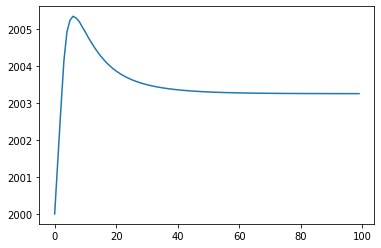

In [32]:
plt.plot(var_hist['s'])

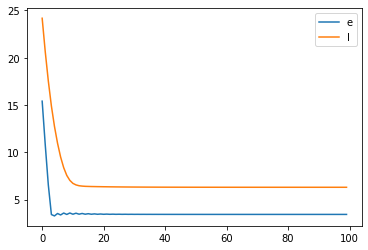

In [33]:
plt.plot(var_hist['e'], label='e')
plt.plot(var_hist['l'], label='l')
plt.legend()

In [34]:
es = tf.linspace(2., 5., 20)
ls = tf.linspace(5., 10., 20)
switches = tf.linspace(2000., 2010., 20)

# Grid approximation

In [35]:
grid = tf.meshgrid(switches, es, ls)

In [36]:
tf.reshape(grid[0], [-1])

<tf.Tensor: shape=(8000,), dtype=float32, numpy=array([2000., 2000., 2000., ..., 2010., 2010., 2010.], dtype=float32)>

In [37]:
log_probs = target_log_prob_fn(model_sigmoid, *[tf.reshape(grid[i], [-1]) for i in range(3)])

In [38]:
log_probs

<tf.Tensor: shape=(8000,), dtype=float32, numpy=
array([-139.2846 , -138.14435, -137.35368, ..., -142.8981 , -144.07274,
       -145.30519], dtype=float32)>

In [39]:
log_probs = tf.reshape(log_probs, [20]*3)

In [40]:
es[10], ls[10]

(<tf.Tensor: shape=(), dtype=float32, numpy=3.5789473>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.631579>)

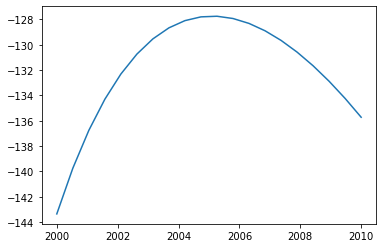

In [41]:
plt.plot(switches, log_probs[:,10,10])

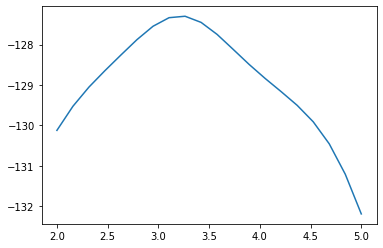

In [42]:
plt.plot(es, log_probs[10,:,10])

# MCMC

In [43]:
state = tf.constant([0.3])
sigma = 0.1
N = 60
k = 34
accept = []
hist = []
for _ in range(500):
    candidate = state + tfd.Uniform(-sigma, sigma).sample(1)
    candidate = max(min(candidate, 1), 0)
    alpha = tfd.Binomial(N, probs=candidate).prob(k) / tfd.Binomial(N, probs=state).prob(k)
    u = tfd.Uniform(0., 1.).sample(1)
    if u <= alpha:
        state = candidate
        accept.append(1.)
    else:
        accept.append(0.)
    hist.append(state.numpy()[0])

In [44]:
tf.reduce_mean(accept)

<tf.Tensor: shape=(), dtype=float32, numpy=0.694>

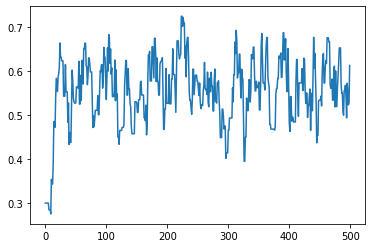

In [45]:
plt.plot(hist)

(array([ 4.,  6.,  0.,  3.,  0.,  4.,  3., 15., 35., 30., 36., 69., 68.,
        66., 47., 49., 30., 24.,  6.,  5.]),
 array([0.2754498 , 0.29786283, 0.3202758 , 0.34268883, 0.36510184,
        0.38751483, 0.40992785, 0.43234086, 0.45475388, 0.47716686,
        0.49957988, 0.52199286, 0.5444059 , 0.5668189 , 0.5892319 ,
        0.6116449 , 0.63405794, 0.6564709 , 0.6788839 , 0.7012969 ,
        0.72370994], dtype=float32),
 <BarContainer object of 20 artists>)

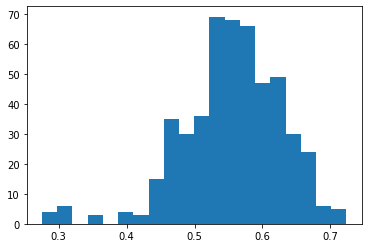

In [46]:
plt.hist(hist, bins=20)

In [24]:
tfb = tfp.bijectors

@tf.function(autograph=False, experimental_compile=False)
def make_chain(target_log_prob_fn, n_chains, num_results, num_burnin_steps):
    kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          # The switchpoint is constrained between zero and len(years).
          # Hence we supply a bijector that maps the real numbers (in a
          # differentiable way) to the interval (0;len(yers))
          tfb.Sigmoid(low=float(years.min()), high=float(years.max())),
          # Early and late disaster rate: The exponential distribution is
          # defined on the positive real numbers
          tfb.Softplus(),
          tfb.Softplus(),
      ])
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

    states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          #tf.ones([n_chains], name='init_switchpoint')*float(years.min() + (years.max() - years.min())/2),
          tfd.Uniform(float(years.min()), float(years.max())).sample(n_chains),
          tf.ones([n_chains], name='init_early_disaster_rate'),
          tf.ones([n_chains], name='init_late_disaster_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
    return states

switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args), 4, 10000, 3000)]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args), 4, 10000, 3000)]
switch_samples_raw = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args), 4, 1000, 0)]
sigmoid_samples_raw = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args), 4, 1000, 0)]

In [26]:
import matplotlib.pyplot as plt

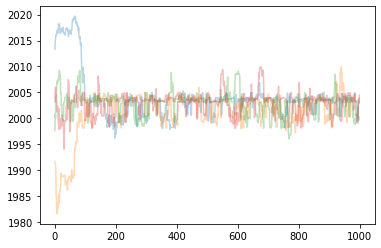

In [27]:
for i in range(4):
    plt.plot(switch_samples_raw[0][:,i], alpha=0.3)

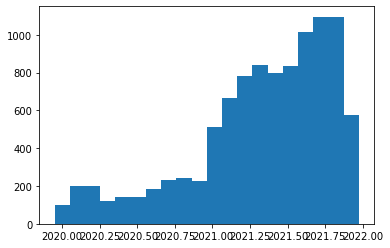

In [28]:
plt.hist(switch_samples[0][:,0], bins=20)
None

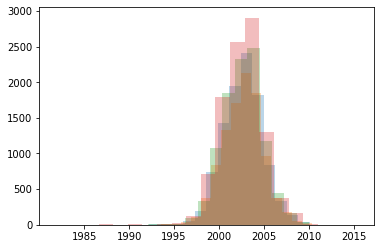

In [29]:
for i in range(4):
    plt.hist(sigmoid_samples[0][:,i], bins=20, alpha=0.3)
None

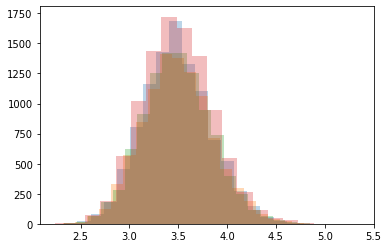

In [30]:
for i in range(4):
    plt.hist(sigmoid_samples[1][:,i], bins=20, alpha=0.3)
None

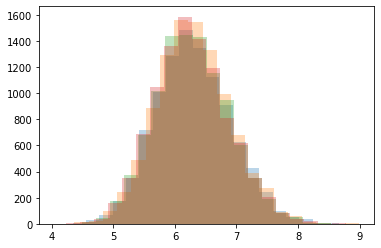

In [31]:
for i in range(4):
    plt.hist(sigmoid_samples[2][:,i], bins=20, alpha=0.3)
None

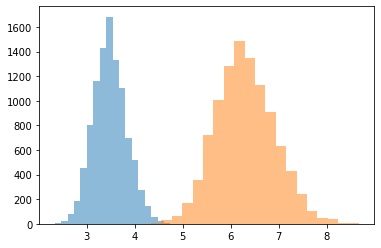

In [32]:
plt.hist(sigmoid_samples[1][:,0], bins=20, alpha=0.5)
plt.hist(sigmoid_samples[2][:,0], bins=20, alpha=0.5)
None

In [33]:
for i, var in enumerate(['switchpoint', 'rate early', 'rate late']):
    print(f"Rhat, {var}: ", tfp.mcmc.potential_scale_reduction(sigmoid_samples[i]))

Rhat, switchpoint:  tf.Tensor(1.0001019, shape=(), dtype=float32)
Rhat, rate early:  tf.Tensor(1.0000447, shape=(), dtype=float32)
Rhat, rate late:  tf.Tensor(1.0006906, shape=(), dtype=float32)


In [34]:
for i, var in enumerate(['switchpoint', 'rate early', 'rate late']):
    print(f"Rhat, {var}: ", tfp.mcmc.potential_scale_reduction(switch_samples[i]))

Rhat, switchpoint:  tf.Tensor(29.241365, shape=(), dtype=float32)
Rhat, rate early:  tf.Tensor(4.8549767, shape=(), dtype=float32)
Rhat, rate late:  tf.Tensor(18.326767, shape=(), dtype=float32)


In [160]:
?tfp.mcmc.potential_scale_reduction

Signature:
tfp.mcmc.potential_scale_reduction(
    chains_states,
    independent_chain_ndims=1,
    split_chains=False,
    validate_args=False,
    name=None,
)
Docstring:
Gelman and Rubin (1992)'s potential scale reduction for chain convergence.

Given `N > 1` states from each of `C > 1` independent chains, the potential
scale reduction factor, commonly referred to as R-hat, measures convergence of
the chains (to the same target) by testing for equality of means.
Specifically, R-hat measures the degree to which variance (of the means)
between chains exceeds what one would expect if the chains were identically
distributed. See [Gelman and Rubin (1992)][1]; [Brooks and Gelman (1998)][2].

Some guidelines:

* The initial state of the chains should be drawn from a distribution
  overdispersed with respect to the target.
* If all chains converge to the target, then as `N --> infinity`, R-hat --> 1.
  Before that, R-hat > 1 (except in pathological cases, e.g. if the chain
  paths were ide